# Ejercicio: Automata Celular de Difusion 2D

## a. Automata discreto con particulas

In [ ]:
%%writefile LatticeGas2D.cpp

#include <iostream>
#include <cmath>
#include "Random64.h"

using namespace std;

const int Lx = 256;
const int Ly = 256;
const double p0 = 0.45, p = 0.13;
const int NAutomatas = 2000;


const int Q = 4;

// ---------------- Declaracion de las clases ----------------

class LatticeGas{
    private:
        int Vx[Q], Vy[Q];
        int *n, *nnew;
    public:
        LatticeGas(void);
        ~LatticeGas(void);
        void Borrese(void);
        void Inicie(int N, double mu[2], double sigma[2], Crandom & ran64);
        int idx(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
        double rho(int ix, int iy, bool UseNew);
        void Muestre(void);
        void Colisione(Crandom & ran64);
        void Adveccione(void);
        double GetSigma2(void);
};

// ---------------- Implementacion de las funciones de las clases ----------------

LatticeGas::LatticeGas(void){
    // Definir los vectores velocidad
    Vx[0] = 1; Vx[1] = 0; Vx[2] = -1; Vx[3] = 0;
    Vy[0] = 0; Vy[1] = 1; Vy[2] = 0; Vy[3] = -1;
    // Crear arreglos dinamicos
    int ArraySize = Lx*Ly*Q;
    n=new int [ArraySize];  nnew=new int [ArraySize];
}
LatticeGas::~LatticeGas(void){
    delete [] n; delete [] nnew;
}

void LatticeGas::Borrese(void){
    for(int ix=0; ix<Lx; ix++)
        for(int iy=0; iy<Ly; iy++)
            for(int i=0; i<Q; i++){
                n[idx(ix,iy,i)] = 0;
                nnew[idx(ix,iy,i)] = 0;
            }
}

void LatticeGas::Inicie(int N, double mu[2], double sigma[2], Crandom & ran64){
    int ix, iy, i;
    while(N > 0){
        // Escogo un sitio al asar usando una distribución bigaussiana
        ix = (int) ran64.gauss(mu[0], sigma[0]); if(ix<0) ix=0; if(ix>=Lx) ix=Lx-1;
        iy = (int) ran64.gauss(mu[1], sigma[1]); if(iy<0) iy=0; if(iy>=Lx) iy=Ly-1;
        // Escogo al azar entre las cuatro direcciones
        i = (int) 4*ran64.r();
        // Si ese sitio esta vacio, lo lleno y decremento n en 1
        if(n[idx(ix,iy,i)] == 0){
            n[idx(ix,iy,i)] = 1;
            N -= 1;
        }
    }
}

void LatticeGas::Muestre(void){
    for(int iy=0; iy<Ly; iy++)
        for(int ix=0; ix<Lx; ix++)
            for(int i=0; i<Q; i++)
                cout << n[idx(ix,iy,i)] << " ";
        cout << endl;
}

double LatticeGas::rho(int ix, int iy, bool UseNew){
    double sum = 0;
    if(UseNew)
        for(int i=0; i<Q; i++) sum += nnew[idx(ix,iy,i)];
    else
        for(int i=0; i<Q; i++) sum += n[idx(ix,iy,i)];
    return sum;
}

double LatticeGas::GetSigma2(void){
    int ix, iy;
    double N = 0;

    // Calcular cuantas bolitas hay
    for(ix=0; ix<Lx; ix++)
        for(iy=0; iy<Ly; iy++)
            N += rho(ix, iy, false);

    // Calcular la posición promedio
    double xprom = 0, yprom = 0;
    for(ix=0; ix<Lx; ix++)
        for(iy=0; iy<Ly; iy++){
            xprom += ix*rho(ix, iy, false);
            yprom += iy*rho(ix, iy, false);
        }
    xprom /= N; yprom /= N;

    // Calcular la varianza promedio
    double sigma2x = 0, sigma2y = 0;
    for(ix=0; ix<Lx; ix++)
        for(iy=0; iy<Ly; iy++){
            sigma2x += pow(ix-xprom, 2.0)*rho(ix, iy, false);
            sigma2y += pow(iy-yprom, 2.0)*rho(ix, iy, false);
        }
    sigma2x /= N-1;
    sigma2y /= N-1;

    return sigma2x + sigma2y;
}

void LatticeGas::Colisione(Crandom & ran64){
    double r = ran64.r();
    int i;
    for(int ix=0; ix<Lx;ix++)
        for(int iy=0; iy<Ly;iy++){
            if(r<p0)
                for(i=0; i<Q;i++) nnew[idx(ix,iy,i)] = n[idx(ix,iy,i)]; // Lo dejo igual
            else if(r<p0+p)
                for(i=0; i<Q;i++) nnew[idx(ix,iy,i)] = n[idx(ix,iy,(Q+i-1)%Q)]; // Roto 90 antihorario
            else if(r<p0+2*p)
                for(i=0; i<Q;i++) nnew[idx(ix,iy,i)] = n[idx(ix,iy,(i+1)%Q)]; // Roto 90 horario
            else
                for(i=0; i<Q;i++) nnew[idx(ix,iy,i)] = n[idx(ix,iy,(i+2)%Q)]; // Roto 180
        }
}

void LatticeGas::Adveccione(void){
    int ixnew, iynew;
    for(int ix=0; ix<Lx; ix++)
        for(int iy=0; iy<Ly; iy++)
            for(int i=0; i<Q; i++){
                ixnew = (Lx + ix + Vx[i])%Lx;
                iynew = (Ly + iy + Vy[i])%Ly;
                n[idx(ixnew,iynew,i)] = nnew[idx(ix,iy,i)];
            }
}

double GetSigma2Prom(LatticeGas * Difusion){
    int ix,iy,iautomata;
    //Calcular cuántas bolitas hay
    double N=0;
    for(iautomata=0;iautomata<NAutomatas;iautomata++)
        for(ix=0;ix<Lx;ix++)
            for(iy=0;iy<Ly;iy++)
                N+=Difusion[iautomata].rho(ix,iy,false);
    //Calcular la posición promedio
    double xprom=0, yprom=0;
    for(iautomata=0;iautomata<NAutomatas;iautomata++)
        for(ix=0;ix<Lx;ix++)
            for(iy=0;iy<Ly;iy++){
                xprom+=ix*Difusion[iautomata].rho(ix,iy,false);
                yprom+=iy*Difusion[iautomata].rho(ix,iy,false);
            }
    xprom/=N; yprom/=N;
    //Calcular la varianza promedio
    double Sigma2=0;
    for(iautomata=0;iautomata<NAutomatas;iautomata++)
        for(ix=0;ix<Lx;ix++)
            for(iy=0;iy<Ly;iy++){
                Sigma2+=pow(ix-xprom,2.0)*Difusion[iautomata].rho(ix,iy,false);
                Sigma2+=pow(iy-yprom,2.0)*Difusion[iautomata].rho(ix,iy,false);
            }
    Sigma2/=(N-1);
    return Sigma2;
}


// ---------------- Parte principal  ----------------

int main(void){
    LatticeGas Difusion[NAutomatas];
    Crandom ran64(2);
    int N = 1200; double mu[2] = {Lx/2, Ly/2}, sigma[2] ={Lx/16, Ly/16};
    int t, tmax = 200;
    int i;

    for(i=0; i<NAutomatas; i++) Difusion[i].Borrese();
    for(i=0; i<NAutomatas; i++) Difusion[i].Inicie(N, mu, sigma, ran64);

    for(t=0; t<tmax; t++){
        cout << t << " " << GetSigma2Prom(Difusion) << endl;
        for(i=0; i<NAutomatas; i++) Difusion[i].Colisione(ran64);
        for(i=0; i<NAutomatas; i++) Difusion[i].Adveccione();
    }
    // Difusion.Muestre();
}

Overwriting LatticeGas2D.cpp


In [2]:
%%bash

g++ LatticeGas2D.cpp -O3
./a.out > datos.dat

1.3910947206573676 0.001539723166417767


Text(0, 0.5, '$\\sigma^2$')

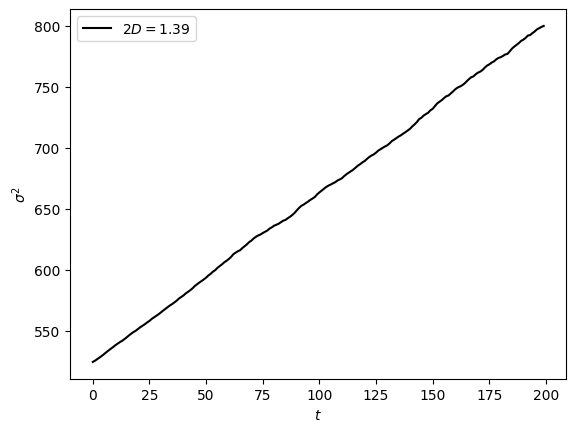

In [3]:
import matplotlib.pyplot as plt
import numpy as np

datos = np.loadtxt("datos.dat")

from scipy.optimize import curve_fit

f = lambda x, m, b: m * x + b
popt, pcov = curve_fit(f, datos[:, 0], datos[:, 1])
print(popt[0], np.sqrt(pcov[0, 0]))
plt.plot(datos[:, 0], datos[:, 1], "k-", label=rf"$2D = {popt[0]:.2f}$")
plt.legend()
plt.xlabel(rf"$t$")
plt.ylabel(rf"$\sigma^2$")

In [4]:
p0 = 0.45
p = 0.13
D_teo = 0.5 * (p + p0) / (1 - (p + p0))
print("Teorico: ",2 * D_teo)

Teorico:  1.3809523809523814


## b. Automata continuo con probabilidades

In [5]:
%%writefile LatticeGas2D_cont.cpp
#include  <iostream>
#include  <cmath>

using namespace std;

const int Lx = 256;
const int Ly = 256;
const double p0 = 0.45, p = 0.13;
const double UmDpmp0 = 1-2*p-p0;

const int Q=4;

// ---------------- Declaracion de las clases ----------------

class LatticeGas{
    private:
        int Vx[Q], Vy[Q];
        double *f, *fnew;
    public:
        LatticeGas(void);
        ~LatticeGas(void);
        int n(int ix, int iy, int i){return (ix*Ly+iy)*Q+i;};
        void Borrese(void);
        void Inicie(double mu[2],double sigma[2]);
        double rho(int ix, int iy, bool UseNew);
        void Colisione(void);
        void Adveccione(void);
        void Show(void);
        double GetSigma2(void);
};

// ---------------- Implementacion de las funciones de las clases ----------------

LatticeGas::LatticeGas(void){
    // Definir los vectores velocidad
    Vx[0] = 1;  Vx[1] = 0; Vx[2] = -1; Vx[3] = 0;
    Vy[0] = 0;  Vy[1] = 1; Vy[2] = 0; Vy[3] = -1;
    // Crear los arreglos dinámicos
    int ArraySize = Lx * Ly * Q;
    f = new double [ArraySize]; fnew = new double [ArraySize];
}

LatticeGas::~LatticeGas(void){
    delete [] f; delete [] fnew;
}

void LatticeGas::Borrese(void){
    for(int ix=0;ix<Lx;ix++)
        for(int iy=0;iy<Ly;iy++)
            for(int i=0;i<Q;i++)
                f[n(ix,iy,i)] = 0;
}

void LatticeGas::Inicie(double mu[2], double sigma[2]){
    for(int ix=0;ix<Lx;ix++)
        for(int iy=0;iy<Ly;iy++)
            for(int i=0;i<Q;i++)
                f[n(ix,iy,i)]=fnew[n(ix,iy,i)]=0.5/(sigma[0]*sqrt(2*M_PI))*exp(-0.5*pow((ix-mu[0])/sigma[0],2.0))
                *0.5/(sigma[1]*sqrt(2*M_PI))*exp(-0.5*pow((iy-mu[1])/sigma[1],2.0));
}
double LatticeGas::rho(int ix, int iy, bool UseNew){
    double sum = 0;
    if(UseNew)
        for(int i=0; i<Q; i++) sum += fnew[n(ix,iy,i)];
    else
        for(int i=0; i<Q; i++) sum += f[n(ix,iy,i)];
    return sum;
}

void LatticeGas::Colisione(void){
    int ix, iy, i;
    for(ix=0;ix<Lx;ix++) //para cada celda
        for(iy=0;iy<Ly;iy++){ //para cada celda
            for(i=0;i<Q;i++)
                fnew[n(ix,iy,i)]=p0*f[n(ix,iy,i)]+p*f[n(ix,iy,(i+1)%Q)]+p*f[n(ix,iy,(Q+i-1)%Q)]+UmDpmp0*f[n(ix,iy,(i+2)%Q)];
        }
}

void LatticeGas::Adveccione(void){
    int ixnew, iynew;
    for(int ix=0;ix<Lx;ix++) //para cada celda
        for(int iy=0;iy<Ly;iy++) //para cada celda
            for(int i=0;i<Q;i++){ // y en cada dirección
                ixnew = (ix+Lx+Vx[i])%Lx; iynew = (iy+Ly+Vy[i])%Ly;
                f[n(ixnew,iynew,i)]=fnew[n(ix,iy,i)];
            }
}

void LatticeGas::Show(void){
    for(int ix=0;ix<Lx;ix++){
        for(int iy=0;iy<Ly;iy++){
            cout << ix << " " << iy << " " << rho(ix,iy,true) << endl;
        }
    }
}

double LatticeGas::GetSigma2(void){
    int ix, iy;
    //Calcular cuántas bolitas hay
    double N=0;
    for(ix=0;ix<Lx;ix++)
        for(iy=0;iy<Ly;iy++)
            N +=rho(ix,iy,true);
    //Calcular la posición promedio
    double xprom=0, yprom=0;
    for(ix=0;ix<Lx;ix++)
        for(iy=0;iy<Ly;iy++){
            xprom += ix*rho(ix,iy,true);
            yprom += iy*rho(ix,iy,true);
        }
    xprom/=N; yprom/=N;
    //Calcular la varianza promedio
    double Sigma2=0;
    for(ix=0;ix<Lx;ix++)
        for(iy=0;iy<Ly;iy++){
            Sigma2+=pow(ix-xprom,2.0)*rho(ix,iy,true);
            Sigma2+=pow(iy-yprom,2.0)*rho(ix,iy,true);
        }
    Sigma2/=N;
    return Sigma2;
}

//------------------- FUNCIONES GLOBALES -------


int main(void){
    LatticeGas Difusion;
    double mu[2] = {Lx/2, Ly/2}, sigma[2] ={Lx/16, Ly/16};  int t,tmax = 200;

    Difusion.Borrese();
    Difusion.Inicie(mu, sigma);

    for(t=0;t<tmax;t++){
        cout<<t<<" "<<Difusion.GetSigma2()<<endl;
        Difusion.Colisione();
        Difusion.Adveccione();
    }
    // Difusion.Show();
    return 0;
}

Overwriting LatticeGas2D_cont.cpp


In [6]:
%%bash

g++ LatticeGas2D_cont.cpp -O3
./a.out > datos.dat

1.380598784220437 0.00016201773244521643


Text(0, 0.5, '$\\sigma^2$')

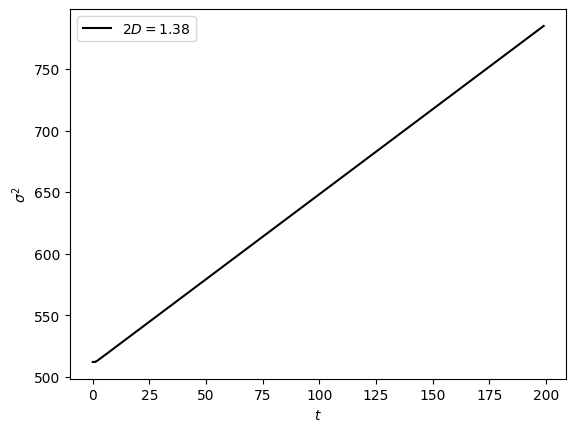

In [7]:
import matplotlib.pyplot as plt
import numpy as np

datos = np.loadtxt("datos.dat")

from scipy.optimize import curve_fit

f = lambda x, m, b: m * x + b
popt, pcov = curve_fit(f, datos[:, 0], datos[:, 1])
print(popt[0], np.sqrt(pcov[0, 0]))
plt.plot(datos[:, 0], datos[:, 1], "k-", label=rf"$2D = {popt[0]:.2f}$")
plt.legend()
plt.xlabel(rf"$t$")
plt.ylabel(rf"$\sigma^2$")

# Ejercicio: Lattice Boltzman 2D para Ondas

## Parte 1: Ley de Snell

Text(0, 0.5, '$n$')

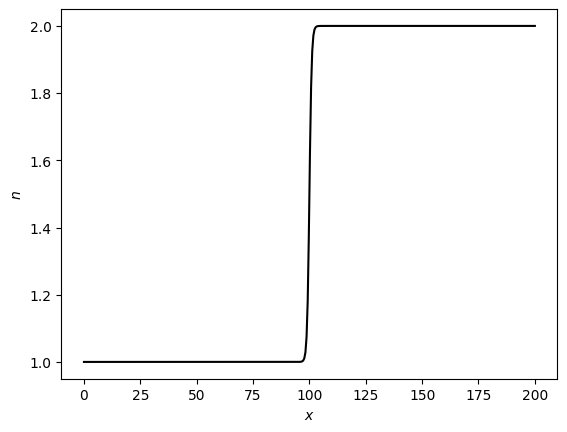

In [8]:
n1 = 1
n2 = 2
x0 = 100
x = np.linspace(0, 200, 400)
y = n1 + (n2 - n1) * 0.5 * (1 + np.tanh((x - x0)))
plt.plot(x, y, "k")
plt.xlabel(rf"$x$")
plt.ylabel(rf"$n$")

In [9]:
%%writefile LB_Ondas_D2Q5.cpp
#include <fstream>
#include <iostream>
#include <cmath>

// --------------- Constantes globales ---------------
const int Lx=400;
const int Ly=200;

const double C = 0.5;
const double n1 = 1.0, n2 = 2.0;
const double thetai = 30.0 * M_PI / 180;

const int Q=5;
const double W0=1.0/3;

const double tau=0.5;
const double Utau=1.0/tau;
const double UmUtau=1-Utau;

using namespace std;

// --------------- Declaración de clases ---------------

class LatticeBoltzmann{
    private:
        double w[Q];      // Pesos
        int Vx[Q],Vy[Q];  // Vectores velocidad
        double *f, *fnew; // Funciones de distribución
    public:
        LatticeBoltzmann(void);
        ~LatticeBoltzmann(void);
        int n(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
        // --------------- Campos macroscopicos ---------------
        double rho(int ix, int iy, bool UseNew);
        double Jx(int ix, int iy, bool UseNew);
        double Jy(int ix, int iy, bool UseNew);
        double Ccelda(int ix, int iy){
            int ix0 = (int) 100 + tan(thetai)*iy;
            double n = n1 + (n2-n1)*0.5*(1+tanh((ix-ix0)));
            return C / n;
            // return C/n1+0.5*C*(1/n2-1/n1)*(1+tanh(0.8*(ix-ix0)));
        };
        // --------------- Funciones de equilibrio ---------------
        double feq(double rho0, double Jx0, double Jy0, int ix, int iy, int i);
        void Start(double rho0, double Jx0, double Jy0);
        void Collision(void);
        void ImposeFields(int t);
        void Advection(void);
        void Print(const char * NameFile);
};

LatticeBoltzmann::LatticeBoltzmann(void){
    //Set the weights
    w[0]=W0; w[1]=w[2]=w[3]=w[4]=(1.0-W0)/4;

    //Set the velocity vectors
    Vx[0]=0;  Vx[1]=1;  Vx[2]=0;  Vx[3]=-1; Vx[4]=0;
    Vy[0]=0;  Vy[1]=0;  Vy[2]=1;  Vy[3]=0;  Vy[4]=-1;

    //Create the dynamic arrays
    int ArraySize=Lx*Ly*Q;
    f=new double [ArraySize];  fnew=new double [ArraySize];
}

LatticeBoltzmann::~LatticeBoltzmann(void) {
    delete [] f; delete [] fnew;
}

double LatticeBoltzmann::rho(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0];
        else sum+=f[n0];
    }
    return sum;
}

double LatticeBoltzmann::Jx(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vx[i];
        else sum+=f[n0]*Vx[i];
    }
    return sum;
}

double LatticeBoltzmann::Jy(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vy[i];
        else sum+=f[n0]*Vy[i];
    }
    return sum;
}

double LatticeBoltzmann::feq(double rho0, double Jx0,double Jy0, int ix, int iy, int i){
    double C2 = pow(Ccelda(ix,iy),2.0);
    double AUX0 = 1-3*C2*(1-W0);
    if(i>0)
        return 3*w[i]*(C2*rho0+Vx[i]*Jx0+Vy[i]*Jy0);
    else
        return rho0*AUX0;
}

void LatticeBoltzmann::Start(double rho0,double Jx0,double Jy0){
    int ix,iy,i,n0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
                n0=n(ix,iy,i);
                f[n0]=feq(rho0,Jx0,Jy0,ix,iy,i);
                }
}

void LatticeBoltzmann::Collision(void){
    int ix,iy,i,n0; double rho0,Jx0,Jy0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++){
            //compute the macroscopic fields on the cell
            rho0=rho(ix,iy,false); Jx0=Jx(ix,iy,false); Jy0=Jy(ix,iy,false);
            for(i=0;i<Q;i++){ //for each velocity vector
                n0=n(ix,iy,i);
                fnew[n0]=UmUtau*f[n0]+Utau*feq(rho0,Jx0,Jy0,ix,iy,i);
            }
        }
}

void LatticeBoltzmann::ImposeFields(int t){
    int i,ix,iy,n0;
    double lambda,omega,rho0,Jx0,Jy0; lambda=10;
    //an oscillating source at ix=0
    ix=0;
    Jx0=Jx(ix,iy,false); Jy0=Jy(ix,iy,false);
    for(iy=0; iy<Ly;iy++){
        for(i=0;i<Q;i++){
            omega=2*M_PI/lambda*Ccelda(ix,iy); rho0=10*sin(omega*t);
            n0=n(ix,iy,i); fnew[n0]=feq(rho0,Jx0,Jy0,ix,iy,i);
        }
    }
}

void LatticeBoltzmann::Advection(void){
    int ix,iy,i,ixnext,iynext,n0,n0next;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
	            ixnext=(ix+Vx[i]+Lx)%Lx; iynext=(iy+Vy[i]+Ly)%Ly;
	            n0=n(ix,iy,i); n0next=n(ixnext,iynext,i);
	            f[n0next]=fnew[n0]; //periodic boundaries
            }
}

void LatticeBoltzmann::Print(const char * NameFile){
    ofstream MyFile(NameFile); double rho0; int ix,iy;
    for(ix=0;ix<Lx;ix++)
        for(iy=0;iy<Ly;iy++){
            rho0=rho(ix,iy,true);
            MyFile<< ix << " " << iy << " " << rho0 << endl;
        }
        MyFile << endl;
    MyFile.close();
}
// --------------- Funciones globales ---------------

int main(void){

    LatticeBoltzmann Waves;
    int t, tmax=800;
    double rho0=0,Jx0=0,Jy0=0;

    // Start
    Waves.Start(rho0,Jx0,Jy0);

    // Run
    for(t=0;t<tmax;t++){
        Waves.Collision();
        Waves.ImposeFields(t);
        Waves.Advection();
    }
    Waves.Print("Ondas.dat");

    return 0;
}

Writing LB_Ondas_D2Q5.cpp


In [10]:
%%bash

g++ LB_Ondas_D2Q5.cpp -O3
./a.out

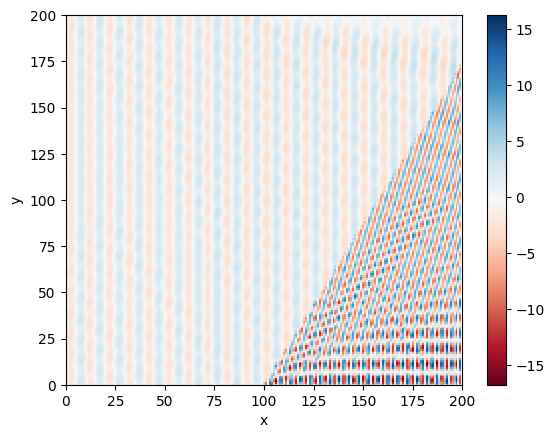

In [11]:
import numpy as np
import matplotlib.pyplot as plt

datos = np.loadtxt("Ondas.dat")

Lx = 400
Ly = 200

L = 200
ix = np.arange(L)
iy = np.arange(L)

iy, ix = np.meshgrid(ix, iy)
rho = datos[:, 2].reshape((Lx, Ly))[:L, :L]

fig, ax = plt.subplots()
ax.set_xlim([0, L])
ax.set_ylim([0, L])
c = ax.pcolormesh(ix, iy, rho, cmap="RdBu")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(c, ax=ax)
fig.savefig("Snell.png", dpi=1200, bbox_inches="tight")

In [12]:
ix = 100 + np.tan(20 * np.pi / 180) * 100
ix

136.39702342662025

Text(0, 0.5, 'Densidad, $\\rho$')

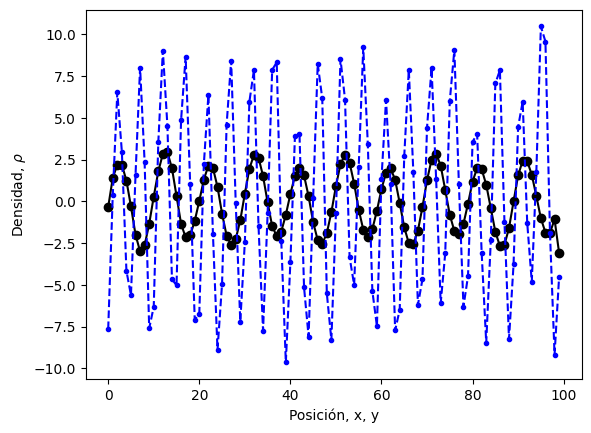

In [13]:
rho_1 = rho[:100, 0][::-1]
rho_2 = rho[100:, 0][::-1]

fig, ax = plt.subplots()
ax.plot(rho_1, "ko-", label=rf"$\rho_1(x)$")
ax.plot(rho_2, "b.--", label=rf"$\rho_2(x)$")
ax.set_xlabel("Posición, x, y")
ax.set_ylabel(rf"Densidad, $\rho$")

In [14]:
from scipy.fft import fft, fftfreq
import numpy as np

T = 1
# Fourier transform
N = rho_1.shape[0]
x = np.linspace(0.0, N, N, endpoint=False)
y = rho_1
yf = fft(y)
xf = fftfreq(N, T)[: N // 2]
yf = np.abs(yf[0 : N // 2])
dx1 = 1 / (xf[np.where(yf == np.max(yf))[0][0]])
print(dx1)

# Fourier transform
N = rho_2.shape[0]
x = np.linspace(0.0, N, N, endpoint=False)
y = rho_2
yf = fft(y)
xf = fftfreq(N, T)[: N // 2]
yf = np.abs(yf[0 : N // 2])
dx2 = 1 / (xf[np.where(yf == np.max(yf))[0][0]])
print(dx2)

10.0
5.0


Text(0, 0.5, 'Densidad, $\\rho$')

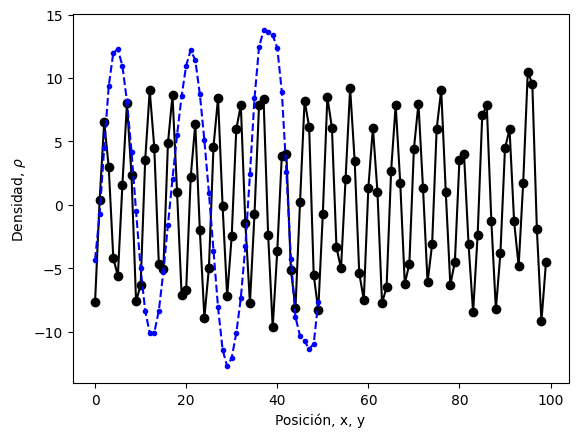

In [15]:
rho_y0 = rho[100:, 0][::-1]
rho_xf = rho[-1, :50][::-1]

fig, ax = plt.subplots()
ax.plot(rho_y0, "ko-", label=rf"$\rho(x,y=100)$")
ax.plot(rho_xf, "b.--", label=rf"$\rho(x=100, y)$")
ax.set_xlabel("Posición, x, y")
ax.set_ylabel(rf"Densidad, $\rho$")

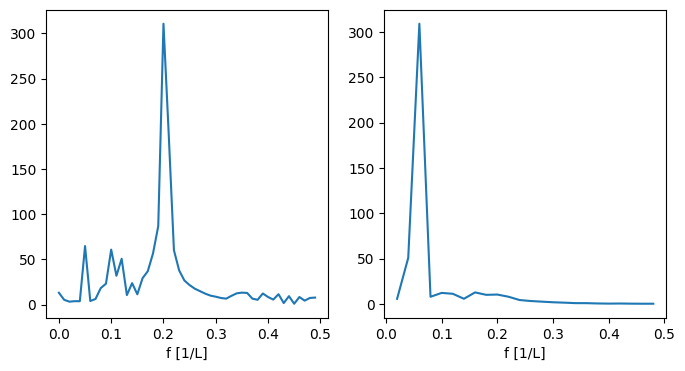

In [16]:
from scipy.fft import fft, fftfreq
import numpy as np

# Plots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

T = 1
# Fourier transform
N = rho_y0.shape[0]
x = np.linspace(0.0, N, N, endpoint=False)
y = rho_y0
yf = fft(y)
xf = fftfreq(N, T)[: N // 2]
yf = np.abs(yf[0 : N // 2])
dx = 1 / (xf[np.where(yf == np.max(yf))[0][0]])

ax[0].plot(xf, yf)
ax[0].set_xlabel("f [1/L]")

N = rho_xf.shape[0]
x = np.linspace(0.0, N, N, endpoint=False)
y = rho_xf
yf = fft(y)
xf = fftfreq(N, 1)[: N // 2]
yf = np.abs(yf[1 : N // 2])
dy = 1 / (xf[1 + np.where(yf == np.max(yf))[0][0]])

ax[1].plot(xf[1:], yf)
ax[1].set_xlabel("f [1/L]")


plt.show()

In [17]:
thetai = 30
# Determinamos el ángulo que forma con ele eje x
theta = np.arctan(dy / dx)
# Usando trigonometria, obtenemos el angulo del rayo refractado
theta_deg = theta * 180 / np.pi
theta_exp = thetai - (90 - theta_deg)
print(theta_exp)
# Comparación con la teoría
n1 = 1
n2 = 2
theta_teo = np.arcsin(n1 / n2 * np.sin(thetai / 180 * np.pi))
print(theta_teo * 180 / np.pi)

13.300755766006375
14.477512185929923


## Parte 2: Espejo esférico

In [18]:
%%writefile LB_Ondas_D2Q5.cpp
#include <fstream>
#include <iostream>
#include <cmath>

// --------------- Constantes globales ---------------
const int Lx=600;
const int Ly=200;

const double C = 0.5;
const double C2 = C*C;

const int Q=5;
const double W0=1.0/3;

const double tau=0.5;
const double Utau=1.0/tau;
const double UmUtau=1-Utau;

using namespace std;

// --------------- Declaración de clases ---------------

class LatticeBoltzmann{
    private:
        double w[Q];      // Pesos
        int Vx[Q],Vy[Q];  // Vectores velocidad
        double *f, *fnew; // Funciones de distribución
    public:
        LatticeBoltzmann(void);
        ~LatticeBoltzmann(void);
        int n(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
        // --------------- Campos macroscopicos ---------------
        double rho(int ix, int iy, bool UseNew);
        double Jx(int ix, int iy, bool UseNew);
        double Jy(int ix, int iy, bool UseNew);
        // --------------- Funciones de equilibrio ---------------
        double feq(double rho0, double Jx0, double Jy0, int ix, int iy, int i);
        void Start(double rho0, double Jx0, double Jy0);
        void Collision(void);
        void ImposeFields(int t);
        void Advection(void);
        void Print(const char * NameFile);
};

LatticeBoltzmann::LatticeBoltzmann(void){
    //Set the weights
    w[0]=W0; w[1]=w[2]=w[3]=w[4]=(1.0-W0)/4;

    //Set the velocity vectors
    Vx[0]=0;  Vx[1]=1;  Vx[2]=0;  Vx[3]=-1; Vx[4]=0;
    Vy[0]=0;  Vy[1]=0;  Vy[2]=1;  Vy[3]=0;  Vy[4]=-1;

    //Create the dynamic arrays
    int ArraySize=Lx*Ly*Q;
    f=new double [ArraySize];  fnew=new double [ArraySize];
}

LatticeBoltzmann::~LatticeBoltzmann(void) {
    delete [] f; delete [] fnew;
}

double LatticeBoltzmann::rho(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0];
        else sum+=f[n0];
    }
    return sum;
}

double LatticeBoltzmann::Jx(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vx[i];
        else sum+=f[n0]*Vx[i];
    }
    return sum;
}

double LatticeBoltzmann::Jy(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vy[i];
        else sum+=f[n0]*Vy[i];
    }
    return sum;
}

double LatticeBoltzmann::feq(double rho0, double Jx0,double Jy0, int ix, int iy, int i){
    double AUX0 = 1-3*C2*(1-W0);
    if(i>0)
        return 3*w[i]*(C2*rho0+Vx[i]*Jx0+Vy[i]*Jy0);
    else
        return rho0*AUX0;
}

void LatticeBoltzmann::Start(double rho0,double Jx0,double Jy0){
    int ix,iy,i,n0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
                n0=n(ix,iy,i);
                f[n0]=feq(rho0,Jx0,Jy0,ix,iy,i);
                }
}

void LatticeBoltzmann::Collision(void){
    int ixc=50, iyc=100, R=100;
    int ix,iy,i,n0; double rho0,Jx0,Jy0;
    int n0i, n0f;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++){
            rho0=rho(ix,iy,false); Jx0=Jx(ix,iy,false); Jy0=Jy(ix,iy,false);
            // Spherical mirror
            if(((ix-ixc)*(ix-ixc) + (iy-iyc)*(iy-iyc) >= R*R) && 100 <= ix && ix <= 200){
                n0=n(ix,iy,0); fnew[n0]=f[n0];
                for(i=1;i<=Q/2;i++){
                    n0i=n(ix,iy,i); n0f=n(ix,iy,i+Q/2);
                    fnew[n0f]=f[n0i]; fnew[n0i]=f[n0f];
                }
            }
            else{
                //compute the macroscopic fields on the cell
                for(i=0;i<Q;i++){ //for each velocity vector
                    n0=n(ix,iy,i);
                    fnew[n0]=UmUtau*f[n0]+Utau*feq(rho0,Jx0,Jy0,ix,iy,i);
                }
            }
        }
}
void LatticeBoltzmann::ImposeFields(int t){
    int i,ix,iy,ixc,iyc,R,n0;
    double lambda,omega,rho0,Jx0,Jy0; lambda=10;
    //an oscillating source at ix=0
    ix=0;
    Jx0=Jx(ix,iy,false); Jy0=Jy(ix,iy,false);
    for(iy=0; iy<Ly;iy++){
        for(i=0;i<Q;i++){
            omega=2*M_PI/lambda*C; rho0=10*sin(omega*t);
            n0=n(ix,iy,i); fnew[n0]=feq(rho0,Jx0,Jy0,ix,iy,i);
        }
    }
    // Spherical mirror
    // ixc=50; iyc=100; R=100;
    // for(ix=0;ix<Lx;ix++){
    //     for(iy=0;iy<Ly;iy++){
    //         if(((ix-ixc)*(ix-ixc) + (iy-iyc)*(iy-iyc) > R*R) && 100 <= ix && ix <= 200)
    //             for(i=0;i<Q;i++){n0=n(ix,iy,i); fnew[n0]=feq(0.0,0.0,0.0,ix,iy,i);}
    //     }
    // }
}

void LatticeBoltzmann::Advection(void){
    int ix,iy,i,ixnext,iynext,n0,n0next;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
	            ixnext=(ix+Vx[i]+Lx)%Lx; iynext=(iy+Vy[i]+Ly)%Ly;
	            n0=n(ix,iy,i); n0next=n(ixnext,iynext,i);
	            f[n0next]=fnew[n0]; //periodic boundaries
            }
}

void LatticeBoltzmann::Print(const char * NameFile){
    ofstream MyFile(NameFile); double rho0; int ix,iy;
    for(ix=0;ix<Lx;ix++)
        for(iy=0;iy<Ly;iy++){
            rho0=rho(ix,iy,true);
            MyFile<< ix << " " << iy << " " << rho0 << endl;
        }
        MyFile << endl;
    MyFile.close();
}
// --------------- Funciones globales ---------------

int main(void){

    LatticeBoltzmann Waves;
    int t, tmax=500;
    double rho0=0,Jx0=0,Jy0=0;

    // Start
    Waves.Start(rho0,Jx0,Jy0);

    // Run
    for(t=0;t<tmax;t++){
        Waves.Collision();
        Waves.ImposeFields(t);
        Waves.Advection();
    }
    Waves.Print("Ondas.dat");

    return 0;
}

Overwriting LB_Ondas_D2Q5.cpp


In [19]:
%%bash

g++ LB_Ondas_D2Q5.cpp -O3
./a.out

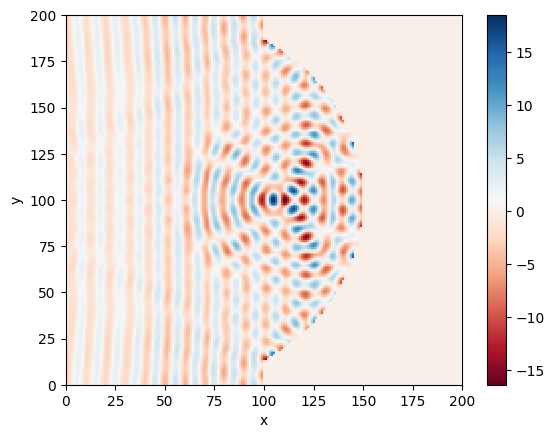

In [20]:
import numpy as np
import matplotlib.pyplot as plt

datos = np.loadtxt("Ondas.dat")

Lx = 600
Ly = 200

L = 200
ix = np.arange(L)
iy = np.arange(L)

iy, ix = np.meshgrid(ix, iy)
rho = datos[:, 2].reshape((Lx, Ly))[:L, :L]

fig, ax = plt.subplots()
ax.set_xlim([0, L])
ax.set_ylim([0, L])
c = ax.pcolormesh(ix, iy, rho, cmap="RdBu")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(c, ax=ax)
fig.savefig("Esferico.png", dpi=1000, bbox_inches="tight")

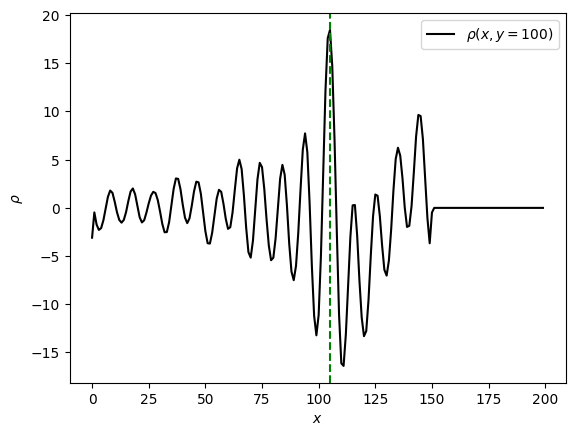

150 - x0 = 45


In [21]:
x = np.arange(L)
y = rho[:, 100]
x0 = x[y==np.max(y)]
fig, ax = plt.subplots()
ax.plot(x,y,label=rf"$\rho(x,y=100)$",color="black")
ax.axvline(x0,color="green",ls="--")
ax.legend()
ax.set_xlabel(rf"$x$")
ax.set_ylabel(rf"$\rho$")
plt.show()

print(f"150 - x0 = {150-x0[0]}")

fig.savefig('FocalEsferico.png', dpi=1000, bbox_inches='tight')

# Ejercicio: Fluidos

## Parte 1 y 2: Fuerza de Arrastre (`omega = 0`) y Magnus

In [22]:
%%writefile LB_D2Q9.cpp
#include <fstream>
#include <iostream>
#include <cmath>

// --------------- Constantes globales ---------------
const int Lx=512;
const int Ly=2*64;

const int Q = 9;

const double tau=1.5;
const double Utau=1.0/tau;
const double UmUtau=1-Utau;

const double nu = 1/3 * (tau-0.5);

using namespace std;

// --------------- Declaración de clases ---------------

class LatticeBoltzmann{
    private:
        double w[Q];      // Pesos
        int Vx[Q],Vy[Q];  // Vectores velocidad
        double *f, *fnew; // Funciones de distribución
    public:
        LatticeBoltzmann(void);
        ~LatticeBoltzmann(void);
        int n(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
        // --------------- Campos macroscopicos ---------------
        double rho(int ix, int iy, bool UseNew);
        double Jx(int ix, int iy, bool UseNew);
        double Jy(int ix, int iy, bool UseNew);
        double sigmaxx(int ix, int iy, double p, double Ux[Q], double Uy[Q]);
        double sigmayy(int ix, int iy, double p, double Ux[Q], double Uy[Q]);
        double sigmaxy(int ix, int iy, double p, double Ux[Q], double Uy[Q]);
        double InterpolatePhi(double x, double y, double Phi[4]);
        void CalculateForces(int ixc, int iyc, int N, int R);
        double F[2];      // Fuerzas en el cilindro
        // --------------- Funciones de equilibrio ---------------
        double feq(double rho0,double Ux0,double Uy0,int i);
        void Start(double rho0,double UJx0,double Uy0);
        void Collision(void);
        void ImposeFields(double Ufan, int ixc, int iyc, int R, double omega);
        void Advection(void);
        void Print(const char * NameFile,double Ufan);
};

LatticeBoltzmann::LatticeBoltzmann(void){
    //Set the weights
    w[0]=4.0/9; w[1]=w[2]=w[3]=w[4]=1.0/9; w[5]=w[6]=w[7]=w[8]=1.0/36;

    //Set the velocity vectors
    Vx[0]=0;  Vx[1]=1;  Vx[2]=0;  Vx[3]=-1; Vx[4]=0;
    Vy[0]=0;  Vy[1]=0;  Vy[2]=1;  Vy[3]=0;  Vy[4]=-1;

    Vx[5]=1;  Vx[6]=-1; Vx[7]=-1; Vx[8]=1;
    Vy[5]=1;  Vy[6]=1;  Vy[7]=-1; Vy[8]=-1;    //Create the dynamic arrays
    int ArraySize=Lx*Ly*Q;
    f=new double [ArraySize];  fnew=new double [ArraySize];
}

LatticeBoltzmann::~LatticeBoltzmann(void) {
    delete [] f; delete [] fnew;
}

double LatticeBoltzmann::rho(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0];
        else sum+=f[n0];
    }
    return sum;
}

double LatticeBoltzmann::Jx(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vx[i];
        else sum+=f[n0]*Vx[i];
    }
    return sum;
}

double LatticeBoltzmann::Jy(int ix, int iy, bool UseNew){
    double sum; int i, n0;
    for(sum=0,i=0;i<Q;i++){
        n0=n(ix,iy,i);
        if (UseNew) sum+=fnew[n0]*Vy[i];
        else sum+=f[n0]*Vy[i];
    }
    return sum;
}

double LatticeBoltzmann::sigmaxx(int ix, int iy, double p, double Ux[Q], double Uy[Q]){
    double dUxdx = 0; double eta = nu * 3 * p;
    for(int i=0; i<Q; i++){dUxdx += w[i]*Vx[i]*Ux[i];}
    return 6*eta*dUxdx - p;
}

double LatticeBoltzmann::sigmayy(int ix, int iy, double p, double Ux[Q], double Uy[Q]){
    double dUydy = 0; double eta = nu * 3 * p;
    for(int i=0; i<Q; i++){dUydy += w[i]*Vy[i]*Uy[i];}
    return 6*eta*dUydy - p;
}

double LatticeBoltzmann::sigmaxy(int ix, int iy, double p, double Ux[Q], double Uy[Q]){
    double sum = 0; double eta = nu * 3 * p;
    for(int i=0; i<Q; i++){sum += w[i]*(Vy[i]*Ux[i]  + Vx[i]*Uy[i]);}
    return 3*sum*eta;
}

double LatticeBoltzmann::InterpolatePhi(double x, double y, double Phi[4]){
    double phi, u, v; int ix, iy;
    ix = (int) x; iy = (int) y;
    u = x - ix; v = y - iy;
    phi = Phi[0]*(1-u)*(1-v) + Phi[1]*u*(1-v) + Phi[2]*v*(1-u) + Phi[3]*u*v;
    return phi;
}

void LatticeBoltzmann::CalculateForces(int ixc, int iyc, int N, int R){
    double dAx, dAy, Fx = 0.0, Fy = 0.0;
    double x, y, theta, CosTheta, SinTheta, theta0 = 2.0*M_PI / N;
    double lside = 2*R*tan(theta0/2);

    double Ux[Q], Uy[Q]; double rho0; // To store the velocities
    double Phixx[4], Phiyy[4], Phixy[4]; // To store the fields at the neighboring cells
    double PhixyInt;

    int Dx[4] = {0, 1, 0, 1}, Dy[4] = {0, 0, 1, 1}; // Displacement vectors for neighbor cells
    int j, i, ix, iy;
    for(int n=0; n<N; n++){
        // Calculate the angle and position of the central point of the edge
        theta = theta0 * (0.5 + n); CosTheta = cos(theta); SinTheta = sin(theta);
        x = ixc + R*CosTheta; y = iyc + R*SinTheta;
        dAx = lside*CosTheta; dAy = lside*SinTheta;

        // cout << theta << endl;

        for(j=0; j<4; j++){
            ix = (int) x + Dx[j]; iy = (int) y + Dy[j];
            // Calculate the velocities Ux[Q], Uy[Q]
            rho0 = rho(ix,iy,false);
            for(i = 0; i<Q; i++){
                Ux[i] = Jx(ix+Vx[i],iy+Vy[i],false)/rho0;
                Uy[i] = Jy(ix+Vx[i],iy+Vy[i],false)/rho0;
            }
            Phixx[j] = sigmaxx(ix,iy,rho0/3,Ux,Uy);
            Phiyy[j] = sigmayy(ix,iy,rho0/3,Ux,Uy);
            Phixy[j] = sigmaxy(ix,iy,rho0/3,Ux,Uy);
        }

        // Interpolate with the neighbors values and save to Fx, Fy
        PhixyInt = InterpolatePhi(x,y,Phixy);
        Fx += InterpolatePhi(x,y,Phixx)*dAx + PhixyInt*dAy;
        Fy += PhixyInt*dAx + InterpolatePhi(x,y,Phiyy)*dAy;
    }
    F[0] = Fx; F[1] = Fy;
}

double LatticeBoltzmann::feq(double rho0,double Ux0,double Uy0,int i){
    double UdotVi=Ux0*Vx[i]+Uy0*Vy[i], U2=Ux0*Ux0+Uy0*Uy0;
    return rho0*w[i]*(1+3*UdotVi+4.5*UdotVi*UdotVi-1.5*U2);
}

void LatticeBoltzmann::Start(double rho0,double Ux0,double Uy0){
    int ix,iy,i,n0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
                n0=n(ix,iy,i);
                f[n0]=feq(rho0,Ux0,Uy0,i);
                }
}

void LatticeBoltzmann::Collision(void){
    int ix,iy,i,n0; double rho0,Ux0,Uy0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++){
            //compute the macroscopic fields on the cell
            rho0=rho(ix,iy,false); Ux0=Jx(ix,iy,false)/rho0; Uy0=Jy(ix,iy,false)/rho0;
            for(i=0;i<Q;i++){ //for each velocity vector
                n0=n(ix,iy,i);
                fnew[n0]=UmUtau*f[n0]+Utau*feq(rho0,Ux0,Uy0,i);
            }
        }
}

void LatticeBoltzmann::ImposeFields(double Ufan, int ixc, int iyc, int R, double omega){
    int i,ix,iy,n0; double rho0; double R2=R*R; double Ux0, Uy0;
    //go through all cells, looking if they are fan or obstacle
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++){
            rho0=rho(ix,iy,false); Ux0 = -omega * (iy-iyc); Uy0 = omega * (ix-ixc);
            //fan
            if(ix==0)
                for(i=0;i<Q;i++){n0=n(ix,iy,i); fnew[n0]=feq(rho0,Ufan,0,i);}
            //obstacle
            else if((ix-ixc)*(ix-ixc)+(iy-iyc)*(iy-iyc)<=R2)
                for(i=0;i<Q;i++) {n0=n(ix,iy,i); fnew[n0]=feq(rho0,Ux0,Uy0,i);}
            //An extra point at one side to break the symmetry
            // else if(ix==ixc && iy==iyc+R+1)
            //    for(i=0;i<Q;i++){n0=n(ix,iy,i); fnew[n0]=feq(rho0,0,0,i);}
        }
}

void LatticeBoltzmann::Advection(void){
    int ix,iy,i,ixnext,iynext,n0,n0next;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
	            ixnext=(ix+Vx[i]+Lx)%Lx; iynext=(iy+Vy[i]+Ly)%Ly;
	            n0=n(ix,iy,i); n0next=n(ixnext,iynext,i);
	            f[n0next]=fnew[n0]; //periodic boundaries
            }
}

void LatticeBoltzmann::Print(const char * NameFile,double Ufan){
    ofstream MyFile(NameFile); double rho0,Ux0,Uy0; int ix,iy;
    for(ix=0;ix<Lx;ix+=8){
        for(iy=0;iy<Ly;iy+=4){
            rho0=rho(ix,iy,true); Ux0=Jx(ix,iy,true)/rho0; Uy0=Jy(ix,iy,true)/rho0;
            MyFile<<ix<<" "<<iy<<" "<<Ux0/Ufan*8<<" "<<Uy0/Ufan*4<<endl;
        }
        MyFile<<endl;
    }
    MyFile.close();
}
// --------------- Funciones globales ---------------

int main(void){

    LatticeBoltzmann Air;
    int t, tmax=2000;
    double rho0=1.0,Ufan0=0.2,omega=0.0*M_PI/1000;
    int ixc=128, iyc=Ly/2, R=8;
    int N = 24;


    for(Ufan0=0.1; Ufan0<=0.4;Ufan0+=0.03){
    // for(omega=0; omega<4*M_PI/1000; omega += M_PI/1000/2){
    // for(R=Ly/32; R<Ly/4; R += Ly/32){
    // Start
    Air.Start(rho0,Ufan0,0.0);

    // Run
    for(t=0;t<tmax;t++){
        Air.Collision();
        Air.ImposeFields(Ufan0,ixc,iyc,R,omega);
        Air.Advection();
    }
    Air.CalculateForces(ixc,iyc,N,R);
    Air.Print("datosCampo.dat",Ufan0);
    cout << Ufan0 << " " << Air.F[0] << " " << Air.F[1] << endl;
    // cout << R << " " << Air.F[0] << " " << Air.F[1] << endl;
    }
    return 0;
}

Writing LB_D2Q9.cpp


In [23]:
%%bash

g++ LB_D2Q9.cpp -O3
./a.out > datos.dat

[[ 1.00000e-01  2.21876e-01  3.88578e-16]
 [ 1.30000e-01  3.23377e-01 -1.88738e-15]
 [ 1.60000e-01  4.34900e-01 -1.95677e-15]
 [ 1.90000e-01  5.52482e-01  3.05311e-16]
 [ 2.20000e-01  7.21151e-01  1.80411e-15]
 [ 2.50000e-01  9.28435e-01  8.46545e-16]
 [ 2.80000e-01  1.14058e+00  1.08247e-15]
 [ 3.10000e-01  1.39369e+00  6.80012e-16]
 [ 3.40000e-01  1.67606e+00 -1.70697e-15]
 [ 3.70000e-01  2.01927e+00 -6.66134e-16]]
[1.6915241  2.30230533] [[0.04813446 0.05944898]
 [0.05944898 0.07601535]]


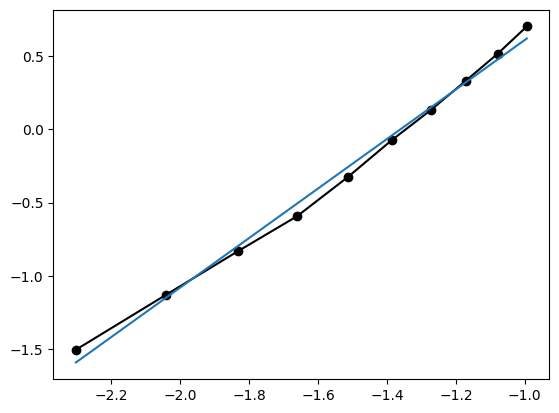

In [24]:
import matplotlib.pyplot as plt
import numpy as np

datos = np.loadtxt("datos.dat")
print(datos)
Ufan = datos[:, 0]
Fx = datos[:, 1]
Fy = datos[:, 2]

fig, ax = plt.subplots()
ax.plot(np.log(Ufan), np.log(Fx), "ko-")

from scipy.optimize import curve_fit

f = lambda x, m, b: m * x + b

popt, pcov = curve_fit(f, np.log(Ufan[:]), np.log(np.abs(Fx[:])))
print(popt, np.sqrt(pcov))

ax.plot(np.log(Ufan), f(np.log(Ufan), *popt))

In [25]:
import numpy as np
import matplotlib.pyplot as plt

datos = np.loadtxt("datosCampo.dat")
Lx = 512 // 8
Ly = 128 // 4
datos = datos.reshape((Lx, Ly, 4))
x, y = np.meshgrid(datos[:, 0, 0], datos[0, :, 1])
vx, vy = datos[:, :, 2].T, datos[:, :, 3].T

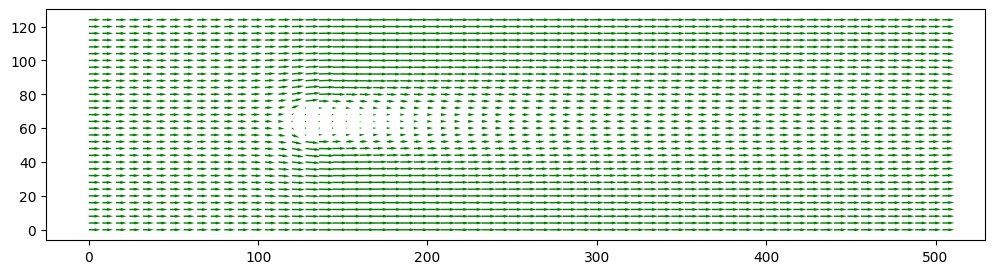

In [26]:
fig, ax = plt.subplots(figsize=(19, 3))
plt.quiver(
    x, y, vx, vy, color="g", linewidth=0.5, headwidth=2, headlength=4, width=0.0015
)
ax.set_aspect("equal")

# Ejercicio: LBM Fluidos en CUDA

In [27]:
%%writefile LB_Fluidos_D2Q9_CUDA.cu

#include <fstream>
#include <iostream>
#include <cmath>

// --------------- Constantes globales ---------------
#define Lx 256
#define Ly 64
#define N 1 //Threads per Block
const int M=(Lx*Ly+N-1)/N; //Blocks per Grid
#define Q 9
const int ArraySize=Lx*Ly*Q;

const float tau=0.55;
const float Utau=1.0/tau;
const float UmUtau=1-Utau;

using namespace std;

// =============== DEVICE PROGRAM (GPU) ===============

//--------------- Constants (Symbols) ----------------
__constant__ float d_w[Q];
__constant__ int d_Vx[Q];
__constant__ int d_Vy[Q];
__constant__ float d_tau[3]; // d_tau[0]=tau,  d_tau[1]=Utau,  d_tau[2]=UmUtau,


//--------------- Functions called by the device itself ---------------
// Can only be called by device functions


__device__ int d_n(int ix, int iy, int i){
    return (ix*Ly+iy)*Q+i;
}

// Macroscopic fields
__device__ float d_rho(int ix,int iy,float *d_f){
    float sum=0; int i,n0;
    for(i=0;i<Q;i++){
        n0=d_n(ix,iy,i); sum+=d_f[n0];
    }
    return sum;
}
__device__ float d_Jx(int ix,int iy,float *d_f){
    float sum=0; int i,n0;
    for(i=0;i<Q;i++){
        n0=d_n(ix,iy,i); sum+=d_Vx[i]*d_f[n0];
    }
    return sum;
}
__device__ float d_Jy(int ix,int iy,float *d_f){
    float sum=0; int i,n0;
    for(i=0;i<Q;i++){
        n0=d_n(ix,iy,i); sum+=d_Vy[i]*d_f[n0];
    }
    return sum;
}
//Equilibrium Functions
__device__ float d_feq(float rho0,float Ux0,float Uy0,int i){
    float UdotVi=Ux0*d_Vx[i]+Uy0*d_Vy[i], U2=Ux0*Ux0+Uy0*Uy0;
    return rho0*d_w[i]*(1+3*UdotVi+4.5*UdotVi*UdotVi-1.5*U2);
}

// --------------- KERNELS ---------------
// Can be called by the host

__global__ void d_Collision(float *d_f,float *d_fnew){
    // Define internal registers
    int icell,ix,iy,i,n0;  float rho0,Ux0,Uy0;

    // Find which thread an which cell should I work
    icell=blockIdx.x*blockDim.x+threadIdx.x;
    ix=icell/Ly; iy=icell%Ly;

    // Compute the macroscopic fields
    rho0=d_rho(ix,iy,d_f); //rho
    Ux0=d_Jx(ix,iy,d_f)/rho0;   //Ux0
    Uy0=d_Jy(ix,iy,d_f)/rho0;   //Uy0

    // Collide and compute fnew
    for(i=0;i<Q;i++){ //on each direction
        n0=d_n(ix,iy,i); d_fnew[n0]=d_tau[2]*d_f[n0]+d_tau[1]*d_feq(rho0,Ux0,Uy0,i);
    }
}

__global__ void d_ImposeFields(float *d_f,float *d_fnew,float Ufan){
    // Define internal registers
    int icell,ix,iy,i,n0;  float rho0; int ixc=Lx/8, iyc=Ly/2, R=Ly/5; float R2=R*R;

    // Find which thread an which cell should I work
    icell=blockIdx.x*blockDim.x+threadIdx.x;
    ix=icell/Ly; iy=icell%Ly;

    rho0=d_rho(ix,iy,d_f);

    //fan
    if(ix==0)
        for(i=0;i<Q;i++){n0=d_n(ix,iy,i); d_fnew[n0]=d_feq(rho0,Ufan,0,i);}
    //obstacle
    else if((ix-ixc)*(ix-ixc)+(iy-iyc)*(iy-iyc)<=R2)
        for(i=0;i<Q;i++){n0=d_n(ix,iy,i); d_fnew[n0]=d_feq(rho0,0,0,i);}
    //An extra point at one side to break the isotropy
    else if(ix==ixc && iy==iyc+R+1)
        for(i=0;i<Q;i++){n0=d_n(ix,iy,i); d_fnew[n0]=d_feq(rho0,0,0,i);}
}

__global__ void d_Advection(float *d_f,float *d_fnew){
    // Define internal registers
    int icell,ix,iy,i,ixnext,iynext,n0,n0next;

    // Find which thread an which cell should I work
    icell=blockIdx.x*blockDim.x+threadIdx.x;
    ix=icell/Ly; iy=icell%Ly;

    // Move the contents to the neighboring cells
    for(i=0;i<Q;i++){ //on each direction
        ixnext=(ix+d_Vx[i]+Lx)%Lx; iynext=(iy+d_Vy[i]+Ly)%Ly;//periodic boundaries
        n0=d_n(ix,iy,i); n0next=d_n(ixnext,iynext,i);
        d_f[n0next]=d_fnew[n0];
    }
}

// =============== HOST PROGRAM (CPU) ===============

// --------------- Declaración de clases ---------------

class LatticeBoltzmann{
    private:
        float h_tau[3]; // h_tau[0]=tau,  h_tau[1]=Utau,  h_tau[2]=UmUtau
        float h_w[Q];      // w[i]
        int h_Vx[Q],h_Vy[Q];  // Vx[i], Vy[i]
        float *h_f, *h_fnew; float *d_f, *d_fnew; // Distribution functions f[n]=f[ix][iy][i]
    public:
        LatticeBoltzmann(void);
        ~LatticeBoltzmann(void);
        int h_n(int ix,int iy,int i){return (ix*Ly+iy)*Q+i;};
        // --------------- Macroscopic Fields ---------------
        float h_rho(int ix, int iy);
        float h_Jx(int ix, int iy);
        float h_Jy(int ix, int iy);
        // --------------- Equilibrium Functions ---------------
        float h_feq(float rho0,float Ux0,float Uy0,int i);
        // --------------- Evolution ---------------
        void Start(float rho0,float Ux0,float Uy0);
        void Collision(void);
        void ImposeFields(float Ufan);
        void Advection(void);
        void Print(const char * NameFile,float Ufan);
};

LatticeBoltzmann::LatticeBoltzmann(void){
    // Charge constants on the Host
    h_tau[0]=tau;  h_tau[1]=Utau;  h_tau[2]=UmUtau;

    //Set the weights --> w[0]=4.0/9; w[1]=w[2]=w[3]=w[4]=1.0/9; w[5]=w[6]=w[7]=w[8]=1.0/36;
    h_w[0]=4.0/9; h_w[1]=h_w[2]=h_w[3]=h_w[4]=1.0/9; h_w[5]=h_w[6]=h_w[7]=h_w[8]=1.0/36;

    //Set the velocity vectors
    h_Vx[0]=0;  h_Vx[1]=1;  h_Vx[2]=0;  h_Vx[3]=-1; h_Vx[4]=0;
    h_Vy[0]=0;  h_Vy[1]=0;  h_Vy[2]=1;  h_Vy[3]=0;  h_Vy[4]=-1;

    h_Vx[5]=1;  h_Vx[6]=-1;  h_Vx[7]=-1;  h_Vx[8]=1;
    h_Vy[5]=1;  h_Vy[6]=1;  h_Vy[7]=-1;  h_Vy[8]=-1;

    // Send to the Device
    cudaMemcpyToSymbol(d_w,h_w,Q*sizeof(float),0,cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_Vx,h_Vx,Q*sizeof(int),0,cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_Vy,h_Vy,Q*sizeof(int),0,cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(d_tau,h_tau,3*sizeof(float),0,cudaMemcpyHostToDevice);

    // Set the distribution functions

    // Build the dynamic matrices on the host
    h_f=new float [ArraySize];  h_fnew=new float [ArraySize];
    // Build the dynamic matrices on the device
    cudaMalloc((void**) &d_f,ArraySize*sizeof(float));
    cudaMalloc((void**) &d_fnew,ArraySize*sizeof(float));
}

LatticeBoltzmann::~LatticeBoltzmann(void) {
    delete[] h_f; delete[] h_fnew;
    cudaFree(d_f); cudaFree(d_fnew);
}

float LatticeBoltzmann::h_rho(int ix, int iy){
    float sum=0; int i, n0;
    for(i=0;i<Q;i++){
        n0=h_n(ix,iy,i);
        sum+=h_fnew[n0];
    }
    return sum;
}
float LatticeBoltzmann::h_Jx(int ix, int iy){
    float sum=0; int i,n0;
    for(i=0;i<Q;i++){
        n0=h_n(ix,iy,i);
        sum+=h_Vx[i]*h_fnew[n0];
    }
    return sum;
}
float LatticeBoltzmann::h_Jy(int ix, int iy){
    float sum=0; int i,n0;
    for(i=0;i<Q;i++){
        n0=h_n(ix,iy,i);
        sum+=h_Vy[i]*h_fnew[n0];
    }
    return sum;
}
float LatticeBoltzmann::h_feq(float rho0,float Ux0,float Uy0,int i){
    float UdotVi=Ux0*h_Vx[i]+Uy0*h_Vy[i], U2=Ux0*Ux0+Uy0*Uy0;
    return rho0*h_w[i]*(1.0+3*UdotVi+4.5*UdotVi*UdotVi-1.5*U2);
}

void LatticeBoltzmann::Start(float rho0,float Ux0,float Uy0){
    int ix,iy,i,n0;
    for(ix=0;ix<Lx;ix++) //for each cell
        for(iy=0;iy<Ly;iy++)
            for(i=0;i<Q;i++){ //on each direction
                n0=h_n(ix,iy,i); h_f[n0]=h_feq(rho0,Ux0,Uy0,i);
                }
    //Send to the Device
    cudaMemcpy(d_f,h_f,ArraySize*sizeof(float),cudaMemcpyHostToDevice);
}

void LatticeBoltzmann::Collision(void){
    // Everything is done on the Device
    dim3 ThreadsPerBlock(N,1,1);
    dim3 BlocksPerGrid(M,1,1);
    d_Collision<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew);
}

void LatticeBoltzmann::ImposeFields(float Ufan){
    dim3 ThreadsPerBlock(N,1,1); //A single thread (in this case)
    dim3 BlocksPerGrid(M,1,1);
    d_ImposeFields<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew,Ufan);
}

void LatticeBoltzmann::Advection(void){
    //Do everything on the Device
    dim3 ThreadsPerBlock(N,1,1);
    dim3 BlocksPerGrid(M,1,1);
    d_Advection<<<BlocksPerGrid,ThreadsPerBlock>>>(d_f,d_fnew);
}

void LatticeBoltzmann::Print(const char * NameFile, float Ufan){
    ofstream MyFile(NameFile); float rho0, Ux0, Uy0; int ix,iy;
    //Bring back the data from Device to Host
    cudaMemcpy(h_fnew,d_fnew,ArraySize*sizeof(float),cudaMemcpyDeviceToHost);
    //Print for gnuplot splot
    for(ix=0;ix<Lx;ix+=4){
        for(iy=0;iy<Ly;iy+=4){
            rho0=h_rho(ix,iy); Ux0=h_Jx(ix,iy)/rho0; Uy0=h_Jy(ix,iy)/rho0;
            MyFile<<ix<<" "<<iy<<" "<<Ux0/Ufan*4<<" "<<Uy0/Ufan*4<<endl;
        }
        MyFile<<endl;
    }
    MyFile.close();
}
// --------------- Funciones globales ---------------

int main(void){

    LatticeBoltzmann Air;
    int t, tmax=5000;
    float rho0=1.0,Ufan0=0.1;

    // Start
    Air.Start(rho0,Ufan0,0.0);

    // Run
    for(t=0;t<tmax;t++){
        Air.Collision();
        Air.ImposeFields(Ufan0);
        Air.Advection();
    }
    Air.Print("WindChannel.dat",Ufan0);

    return 0;
}

Overwriting LB_Fluidos_D2Q9_CUDA.cu


In [28]:
%%bash

time nvcc LB_Fluidos_D2Q9_CUDA.cu
./a.out


real	0m2.051s
user	0m1.596s
sys	0m0.454s


In [29]:
import numpy as np
import matplotlib.pyplot as plt

datos = np.loadtxt("WindChannel.dat")

ix = datos[:, 0]
iy = datos[:, 1]
Ux0 = datos[:, 2]
Uy0 = datos[:, 3]

In [30]:
X = ix.reshape(64, 16)
Y = iy.reshape(64, 16)
U = Ux0.reshape(64, 16)
V = Uy0.reshape(64, 16)

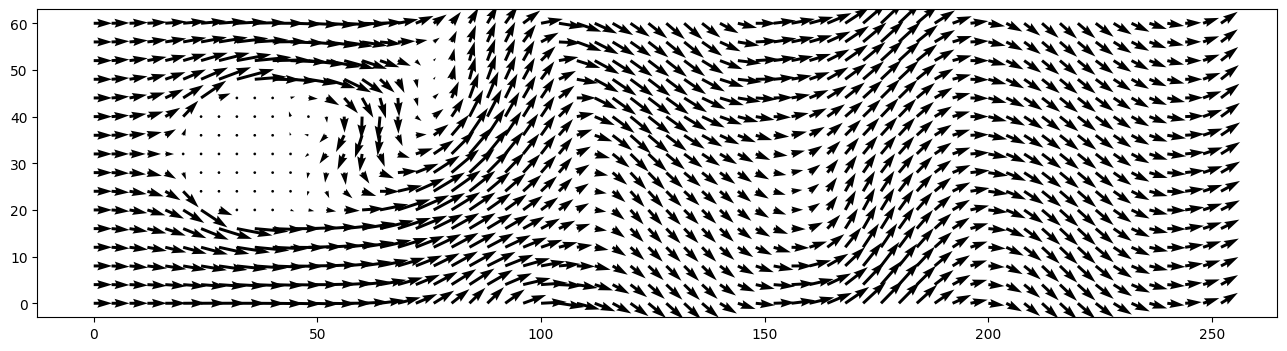

In [31]:
fig, ax = plt.subplots(figsize=(16, 4))
plt.quiver(X, Y, U, V)